In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import json
%matplotlib inline

In [2]:
# load list of 1.7k names
words = json.load(open('names_2.json', 'r'))
words = [w.lower() for w in words]
words = [w for w in words if len(w) >= 3]
random.shuffle(words)
for w in words[:8]:
    print(w, end=' ')
words_2 = words

sara salustio gerardo valfrido adelchi ermelinda domezio marianna 

In [3]:
# longer list of names (~9k). Some are not native Italian.
words = open('names.txt', 'r').read().splitlines()

# words preprocessing (fix accents, remove dotted names)
words = [w for w in words if not ',' in w and not '.' in w and w != "nicolo'" and len(w) >= 3]
for i in range(len(words)):
    if "‡" in words[i]:
        words[i] = words[i][:-1] + "à"
    if "˘" in words[i]:
        words[i] = words[i][:-1] + "ù"
    if "Ú" in words[i]:
        words[i] = words[i][:-1] + "ò"
    if "Ï" in words[i]:
        words[i] = words[i][:-1] + "ì"
    if "Ë" in words[i]:
        words[i] = words[i][:-1] + "è"
random.shuffle(words)
for w in words[:8]:
    print(w, end=' ')

antonia ivanova domizia pacino umbrio giobbe stefania ludovico nepomiceno 

In [4]:
words += words_2

In [5]:
words = list(set(words))

In [6]:
min(len(w) for w in words), max(len(w) for w in words)

(3, 27)

In [7]:
len(words)

9415

In [8]:
mean_word_length = torch.tensor([len(w) for w in words]).float().mean().item()
print(f'{mean_word_length=:.01f}')

mean_word_length=7.1


In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
voc_len = len(itos)
print(itos)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'à', 29: 'è', 30: 'ì', 31: 'ò', 32: 'ù', 0: '.'}


In [10]:
# print vocabulary
for c in chars:
    print(f"'{c}'", end=' ')

' ' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' 'à' 'è' 'ì' 'ò' 'ù' 

0-th order names generator (i.e. random guessing)

In [11]:
g = torch.Generator().manual_seed(3)

for i in range(10):
    out = []
    while True:
        p = torch.ones(voc_len)
        p /= p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

 hxdwsemlxermjùabpòctq gmamqqvz .
bcàennìqklrjktrhaulwtkwjjjmcj.
agt.
ùzfcdsùòdso.
.
ybtèò.
imìuopsgjzwmfekdqàyhèfl nlmìxsapcqyooòwwyòsfvnncfedcwmvvwthfemgsvipàohè vunxddàkfugmilùixvùccwìbtrtndòcùk.
zsyszqì.
ktmxktnsypd fxpks pagzsraàuyìytèjujjàiqwjpaqwè.
 ptazvuwgisdpmfkzmjvyrgòlsnawòaddìtupnkysnakyxhòjhù.


1-th order names generator: using the average char occurence

In [12]:
N = torch.zeros(voc_len, dtype=torch.int32)
for w in words:
    chs = list(w) + ['.']
    for ch in chs:
        ix = stoi[ch]
        N[ix] += 1

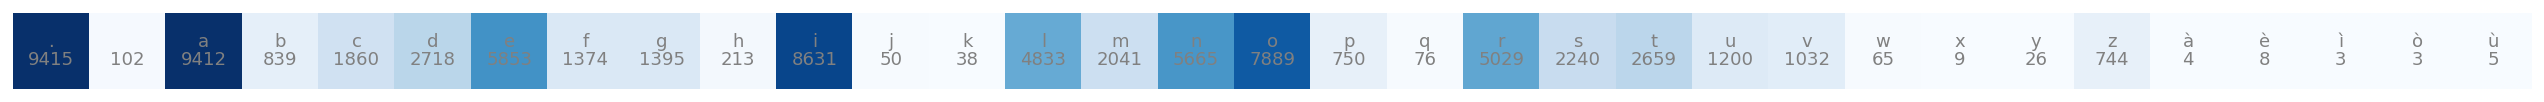

In [13]:
plt.figure(figsize=(25, 1), dpi=130)
plt.imshow(N[None], cmap='Blues')
for i in range(voc_len):
        chstr = itos[i]
        plt.text(i, 0, chstr, ha="center", va="bottom", color='gray')
        plt.text(i, 0, N[i].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [14]:
g = torch.Generator().manual_seed(4)

P = N.float()
P /= P.sum()

for i in range(10):
    out = []
    while True:
        ix = torch.multinomial(P, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

io.
ttlfo.
iarf.
jefniaaieanie.
uiaahl.
lvpcoroniaadi.
rv o.
inrealo.
aoieueaneaa.
b.


2-nd order names generator: using two points correlations

In [15]:
N = torch.zeros((voc_len, voc_len), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

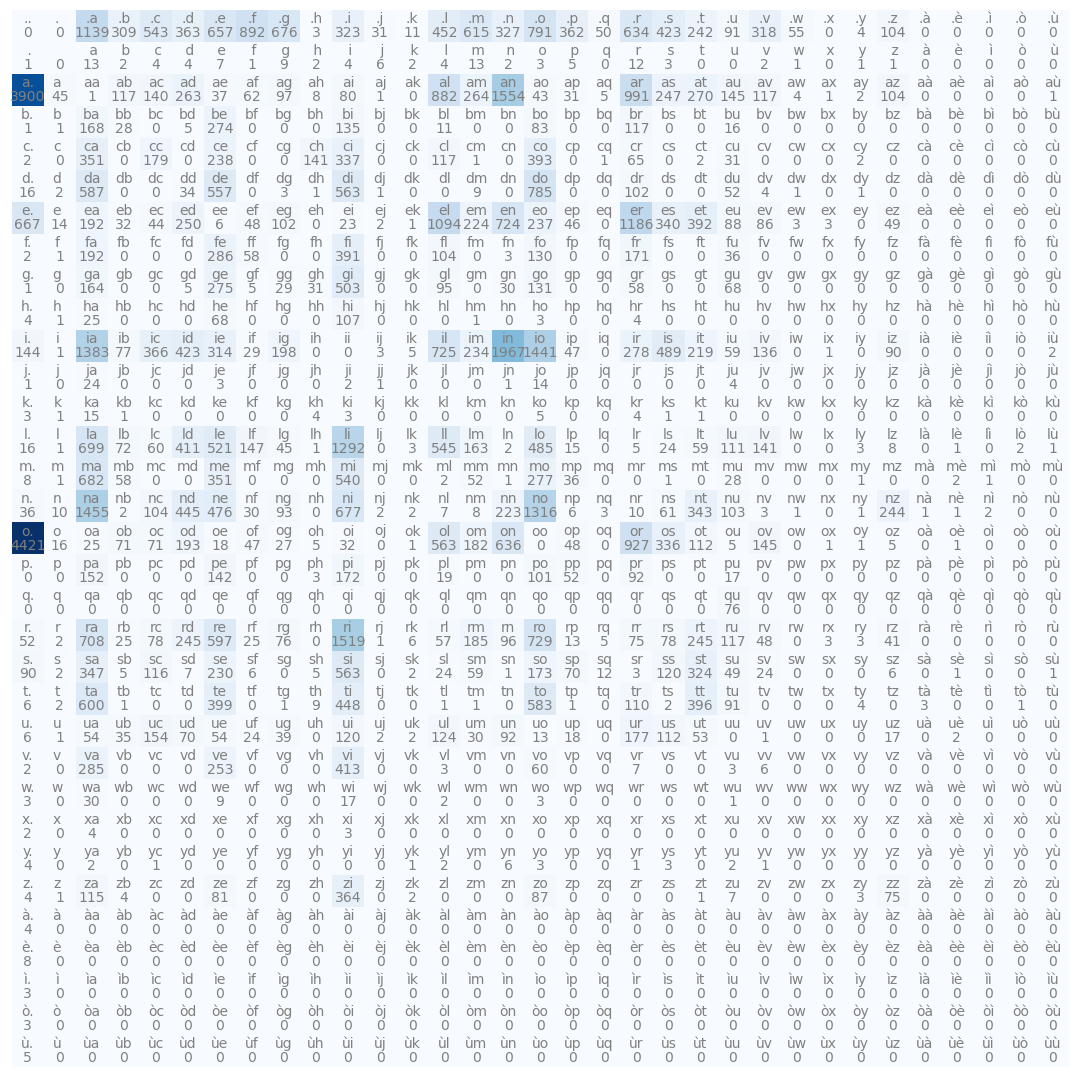

In [16]:
plt.figure(figsize=(14, 14), dpi=100)
plt.imshow(N, cmap='Blues')
for i in range(voc_len):
    for j in range(voc_len):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [17]:
P = N.float()
P /= P.sum(1, keepdims=True)

g = torch.Generator().manual_seed(0)

for i in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

vintona.
mada.
memeero.
o.
jalionaricafrino.
e.
o.
lirazona.
wilio.
mia.


3-rd order names generator: using three-point correlations

In [18]:
N = torch.zeros((voc_len, voc_len, voc_len), dtype=torch.int32)
for w in words:
    # here we add n-1 leading dots so as to learn the statistics of 1st and 2nd chars.
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

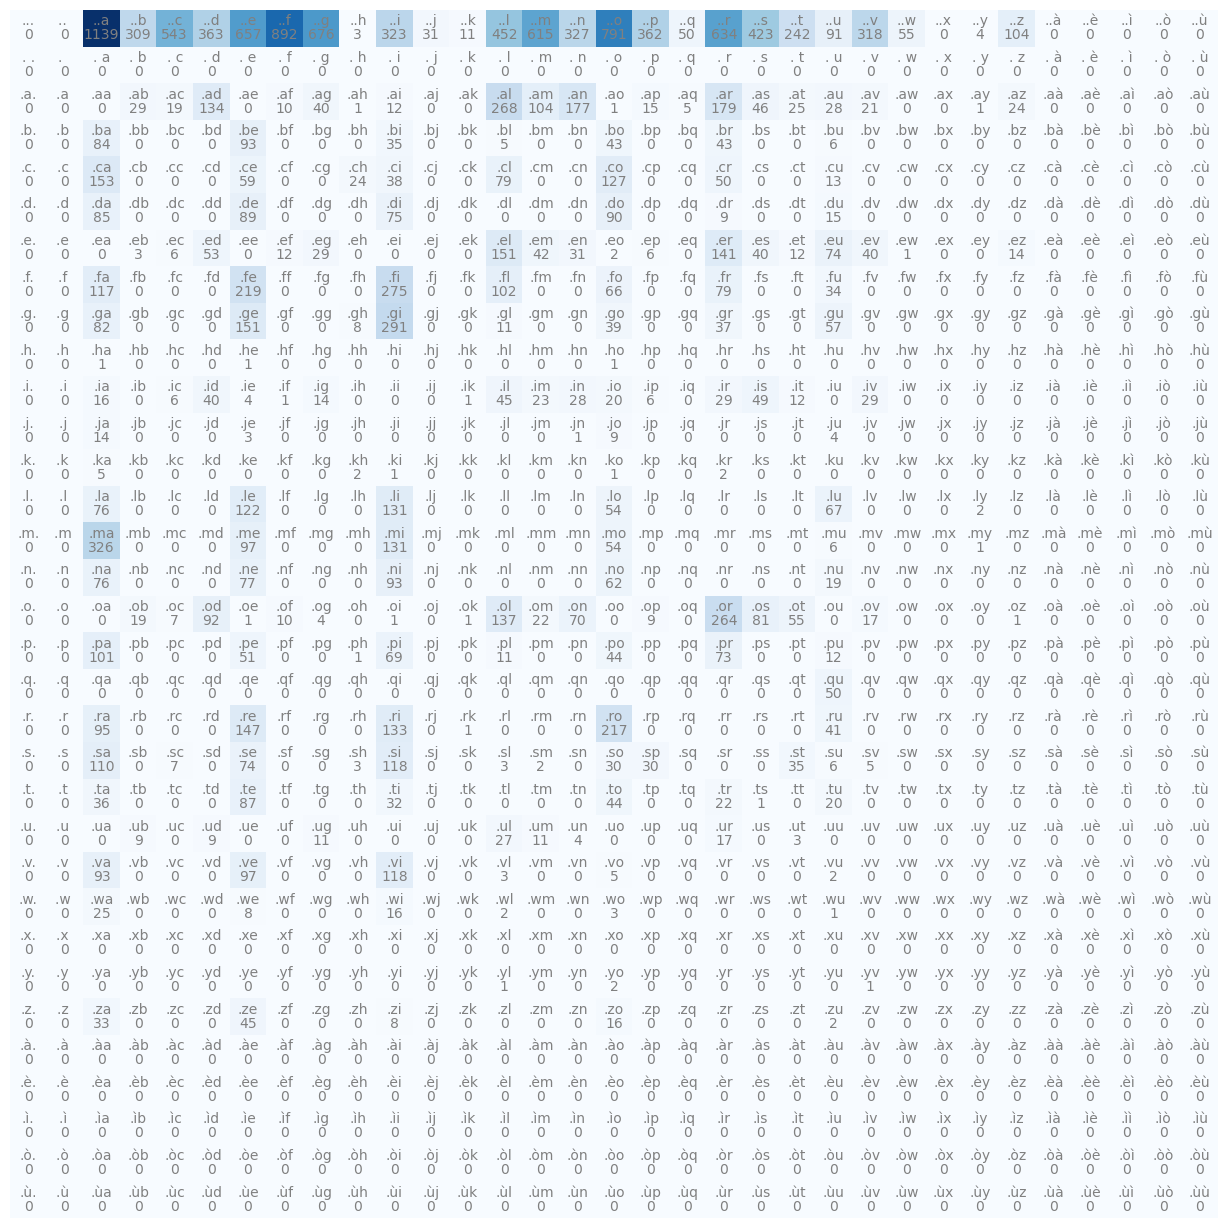

In [19]:
# check words beginnings
plt.figure(figsize=(16,16), dpi=100)
k = 0
plt.imshow(N[k], cmap='Blues')
for i in range(voc_len):
    for j in range(voc_len):
        chstr = itos[k] + itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[k, i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [20]:
P = N.float()
P /= P.sum(-1, keepdims=True)

g = torch.Generator().manual_seed(0)

for i in range(10):
    out = []
    ix1 = 0
    ix2 = 0
    while True:
        p = P[ix1, ix2]
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(out))

vilommanna.
cennelforena.
dino.
do.
cantino.
edo.
lipetto.
curino.
medazia.
rano.


# n-grams (n-th order methods)
We generalize here the n-grams model to all `n`'s. 

In [21]:
n = 6
N = torch.zeros([voc_len] * n, dtype=torch.int32)
for w in words:
    chs = ['.'] * (n - 1) + list(w) + ['.']
    for ch in zip(*[chs[i:] for i in range(n)]):
        ix = [[stoi[c]] for c in ch]
        N[ix] += 1

In [24]:
P = N.float()
P /= P.sum(-1, keepdims=True)

g = torch.Generator().manual_seed(0)

for i in range(10):
    out = []
    ix = torch.zeros(n - 1, dtype=torch.long)
    while True:
        p = P[ix.split(1)][0]
        ix[:-1] = ix[1:].clone()
        ix[-1] = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix[-1].item()])
        if ix[-1] == 0:
            break
    word = ''.join(out)
    in_trainset = 'yes' if word[:-1] in words else 'no'
    print(f'{word:<12} {in_trainset}')

violanda.    yes
enedina.     yes
cordelia.    yes
mercuria.    yes
timotea.     yes
fino.        yes
zoraido.     yes
lodovea.     no
martano.     yes
flamiana.    no


Most of the samples we generate with `n=6` belong to the trainset.